# User Story: (Map) Viewing Global Reach of Organization
## Sophia Wang 
**(github: wangsjoy)**

User is able to see highlighted countries impacted by organization through the custom Details View Controller. Map is implemented using Google Maps SDK - iOS.

Highlighting a country through Google Maps has several broad steps:
1. Create a mutable path object
2. Populate path with the (lat, long) of each coordinate that defines a polygon (i.e. country border)
3. Create a polygon object with the path
4. Set additional features
5. Assign the polygon to the map view

Note: these steps are more specifically described here: https://developers.google.com/maps/documentation/ios-sdk/shapes#maps_ios_shapes_polyline_styles-objective-c

## 1. Finding Border Coordinates

Using the World Borders Dataset (http://thematicmapping.org/downloads/world_borders.php), find the longitude and latitudes which define the borders for each country.

**Files**

Shapefile: TM_WORLD_BORDERS-0.3.shp

Database Structure (containing all country codes by row number - used for indexing into database): TM_WORLD_BORDERS-0.3.csv

### 1.1 Generating Latitude and Longitudes of Borders (contiguous) with plots

Find coordinates of a country's borders, loaded directly from World Borders DB.

In [1]:
#import libraries
import shapefile
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
#Read shapefile for database
shape_file = shapefile.Reader("TM_WORLD_BORDERS-0.3.shp")
shapes = shape_file.shapes()

In [3]:
#function for generating latitude and longitude lists
def coordinate_generator(country_code):
    """
    Generates coordinates for border.
    
    Parameters
    ----------
    country_code : (int) country identifier - found in TM_WORLD_BORDERS-0.3.numbers (row number)

    Returns
    -------
    (tuple)
        two lists representing latitude, longitude, respectively.
    """
    lat = []
    lon = []
    for i in range(len(shapes[country_code].points)):
        lat.append(shapes[country_code].points[i][1])
        lon.append(shapes[country_code].points[i][0])
    return (lat, lon)

In [5]:
#function for plotting border
def plottingCountryBorder(lat, lon, end=True):
    """
    Generates plot of border path.
    
    Parameters
    ----------
    lat : (list) latitudes for each coordinate
    lon : (list) longitudes for each coordinate
    end : (bool) True/False if should connect path between first and last coordinate. 
            Defaults to True.
    Returns
    -------
    None.
    """
    #plot to check the country borders
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    for point in range(len(lat)):
        if ((point == len(lat)-1) and (end)):
            plt.plot([lon[point], lon[0]], [lat[point], lat[0]],
                 color='gray', linestyle='--',
                 transform=ccrs.PlateCarree(),)
        elif ((point == len(lat)-1) and (not end)):
            print("Don't connect last two border coordinates (noncontiguous)")
        else:
            plt.plot([lon[point], lon[point+1]], [lat[point], lat[point+1]],
                 color='gray', linestyle='--',
                 transform=ccrs.PlateCarree(),)
    plt.show()

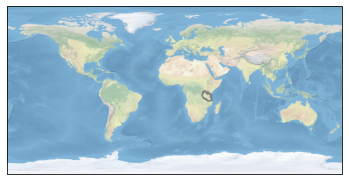

Latitude List:  [-7.993334000000004, -7.996944999999982, -7.996111999999982, -7.976388999999983, -7.9730559999999855, -7.956112000000019, -7.951945000000023, -7.945833999999934, -7.94389000000001, -7.94389000000001, -7.91333400000002, -7.783610999999951, -7.7333340000000135, -7.7069439999999645, -7.683056000000022, -7.674444999999935, -7.659445000000005, -7.646388999999999, -7.638888999999949, -7.642500999999925, -7.652499999999918, -7.6777779999999325, -7.689166999999998, -7.7369449999999915, -7.763333999999986, -7.875277999999923, -7.879444999999919, -7.907222999999931, -7.911112000000003, -7.919444999999996, -7.974999999999966, -7.989444999999932, -7.993334000000004, -6.210555999999997, -6.213888999999995, -6.213888999999995, -6.201666999999986, -6.198333999999932, -6.193610999999919, -6.186666999999943, -6.153889999999933, -6.143888999999945, -6.13222300000001, -6.129444999999976, -6.130278999999973, -6.132777999999973, -6.136944999999969, -6.141666999999984, -6.184722999999963, -6

In [7]:
#example implementation
country_code = 204 #note: 204 corresponds to 'United Republic of Tanzania', as found in TM_WORLD_BORDERS-0.3.numbers
coordinates_tuple = coordinate_generator(country_code)
lat = coordinates_tuple[0]
lon = coordinates_tuple[1]
plottingCountryBorder(lat, lon)

#Printing statements
print("Latitude List: ", lat)
print("Longitude List: ", lon)

### 1.2 Adjusting Latitude and Longitudes of Borders for non-contiguous country borders

Some countries have non-contiguous borders (e.g. do not share a common border). For example, the United States border consists of Alaska, which is not connected to the majority of the states. Failing to adjust borders would result in errors in the creation of a polygon to define the country.

Steps taken to account for non-contiguous country borders:
1. Determine where self-intersecting polygons exist using shapely library functionality (as a self-check).
2. When these country borders are identified, compute what the max distance between two consecutive coordinate points is.
3. Run basic analysis to determine where greatest outliers exist (e.g. from contiguous United States to Alaska, this distance will be large and distinct).
4. Generate grouped coordinates based on contiguous land masses (determined from computing distance between consecutive corodinate points).
5. Within contiguous land masses for a country's borders, keep land masses with sufficient points.
6. Plot all contiguous land masses separately.

**Files**

Current (unadjusted) country borders: Border.json

In [9]:
#Import libraries for polygon check
from shapely.geometry import Polygon

In [10]:
#Clean self-intersecting polygons
coords = [(lat[i], lon[i]) for i in range(len(lat))]
polygon_coords = Polygon(coords)
print(polygon_coords.is_valid)

clean = polygon_coords.buffer(0)
print(clean.is_valid)

False
True


In [11]:
#Import current country borders (does not account for non-contiguous country borders)
import json
with open('Border.json') as borderFile:
  data = json.load(borderFile)

In [13]:
# Import plotting libraries
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#function for calculating distance between two consecutive coordinates
def distanceCalculator(start_point, end_point):
    """
    Calculates distance between two points.
    
    Parameters
    ----------
    start_point : (list) [lat, lon] of first coordinate.
    end_point : (list) [lat, lon] of second coordinate.

    Returns
    -------
    distance : (float) distance.
    """
    distance_x = abs(start_point[0] - end_point[0])
    distance_y = abs(start_point[1] - end_point[1])
    distance = ((distance_x**2) + (distance_y**2))**0.5
    return distance

#function for calculating max distance between all consecutive coordinates which define a country's borders
def maxDistanceCalculator(lat_list, lon_list):
    """
    Calculates max distance between all consecutive coordinates which define a country's borders.
    Generates box and whisker plot to visualize distance between all points.
    
    Parameters
    ----------
    lat_list : (list) latitudes for each coordinate
    lon_list : (list) longitudes for each coordinate

    Returns
    -------
    (float)
        max distance between two consecutive coordinates.
    """
    all_distances = []
    for coord_key in range(len(lat_list)):
        if (coord_key == (len(lat_list)-1)):
            start_point = [lat_list[coord_key], lon_list[coord_key]]
            end_point = [lat_list[0], lon_list[0]]
            all_distances.append(distanceCalculator(start_point, end_point))
        else:
            start_point = [lat_list[coord_key], lon_list[coord_key]]
            end_point = [lat_list[coord_key+1], lon_list[coord_key+1]]
            all_distances.append(distanceCalculator(start_point, end_point))
    #create box and whisker plots
    fig = plt.figure(figsize =(10, 7))
 
    # Creating plot
    plt.boxplot(all_distances)

    # show plot
    plt.show()
    return max(all_distances)

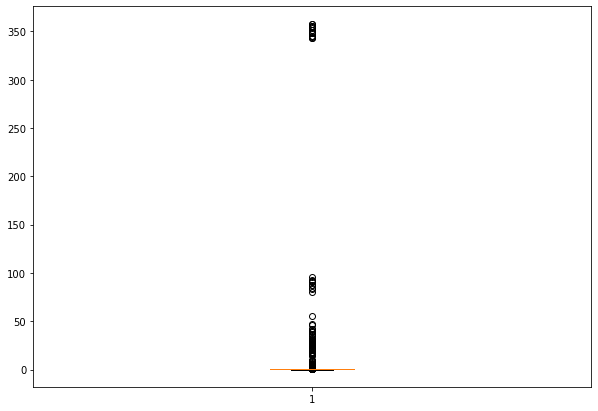

Max Distance for United States is:  357.9556018637702


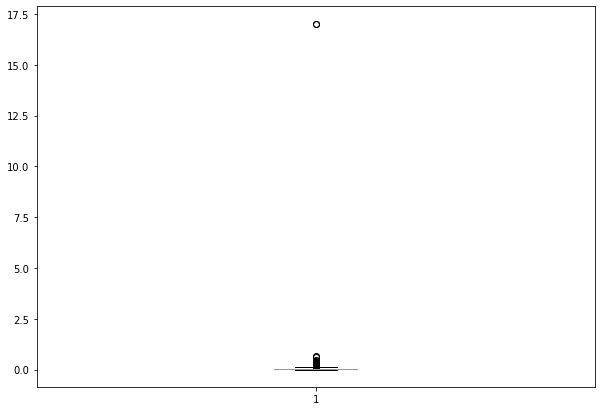

Max Distance for DRC is:  17.027091059716174


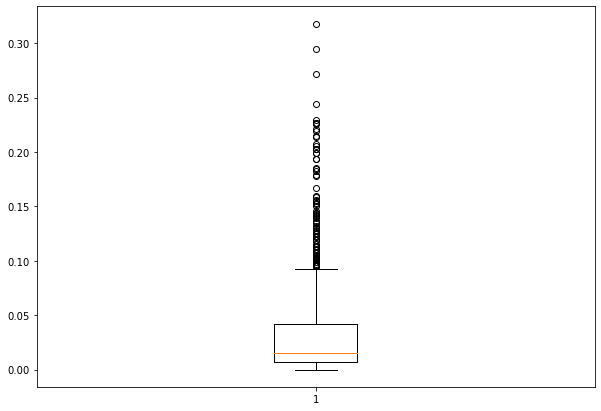

Max Distance for Guinea is:  0.31798693402717126


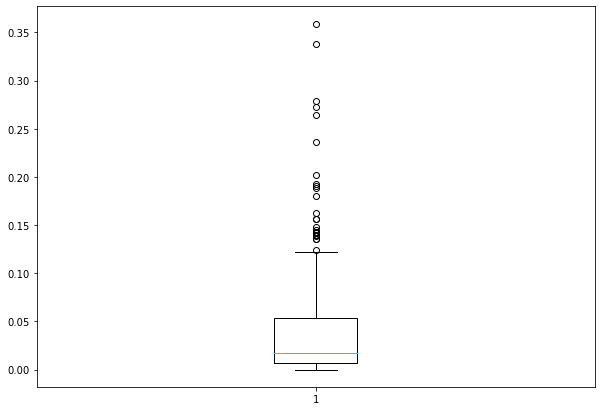

Max Distance for Togo is:  0.35918246446339797


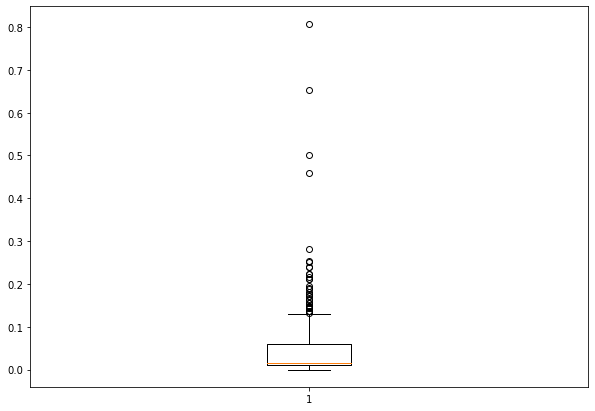

Max Distance for Uganda is:  0.8080561912837504


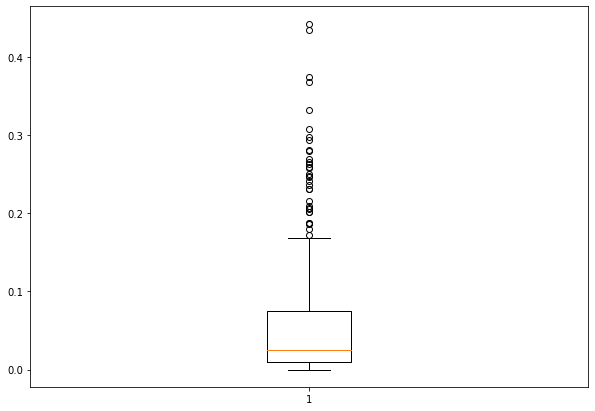

Max Distance for Burkina Faso is:  0.44332407759561215


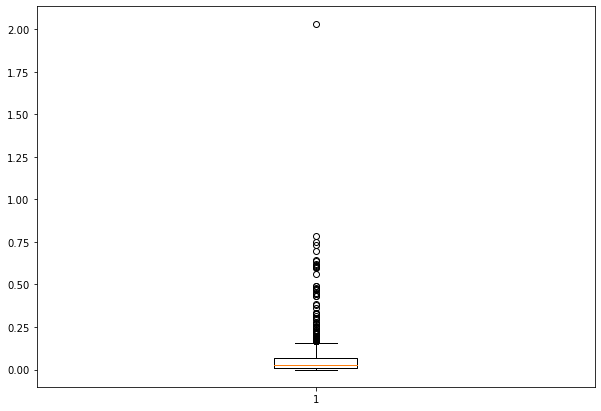

Max Distance for Chad is:  2.033332999999999


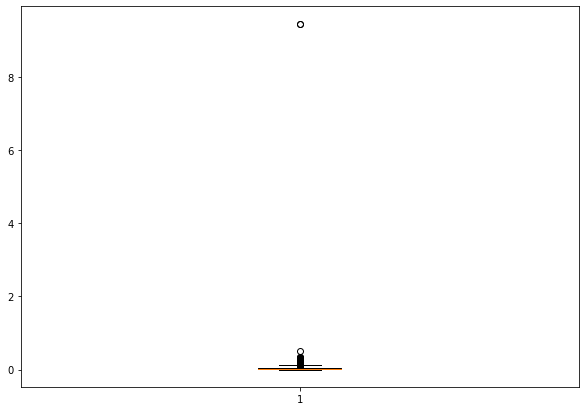

Max Distance for Nigeria is:  9.46266377258985


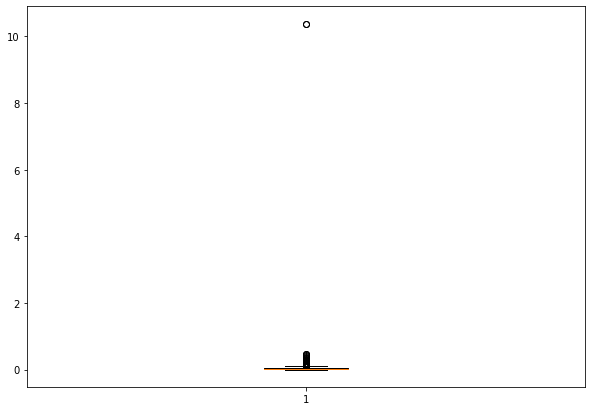

Max Distance for Cameroon is:  10.386958898964155


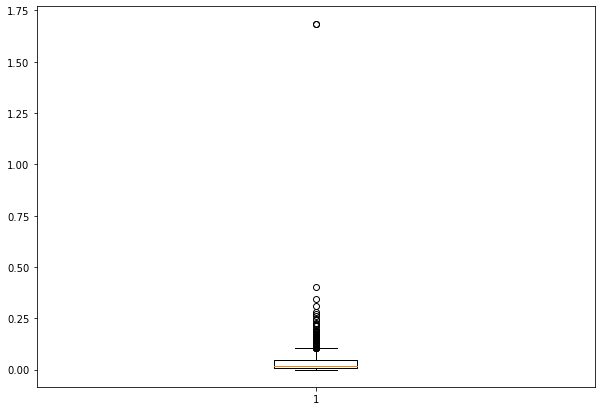

Max Distance for Cote d'Ivoire is:  1.6860304802478974


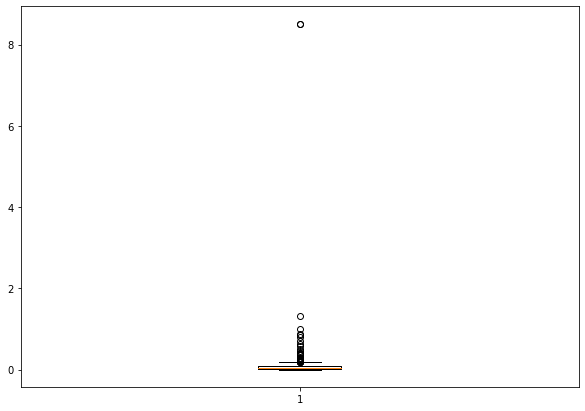

Max Distance for Kenya is:  8.516763873987143


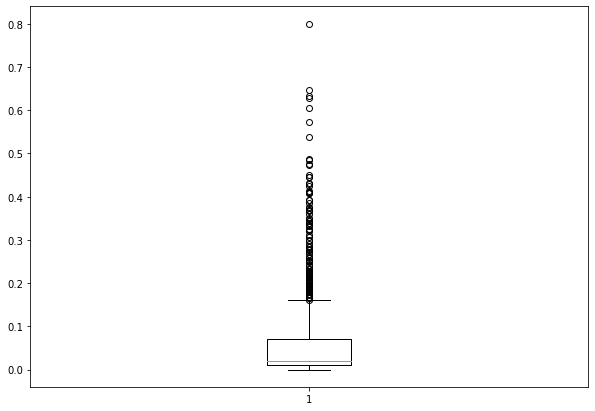

Max Distance for Mali is:  0.8005551937711729


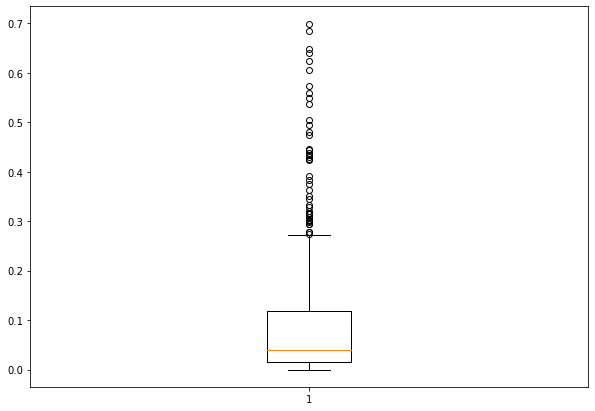

Max Distance for Niger is:  0.699246894709588


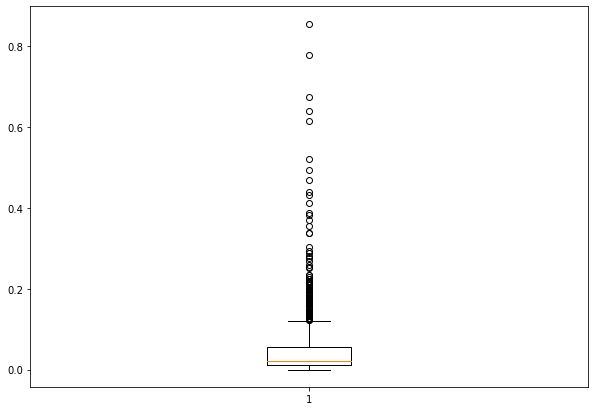

Max Distance for Ethiopia is:  0.8554628448611877


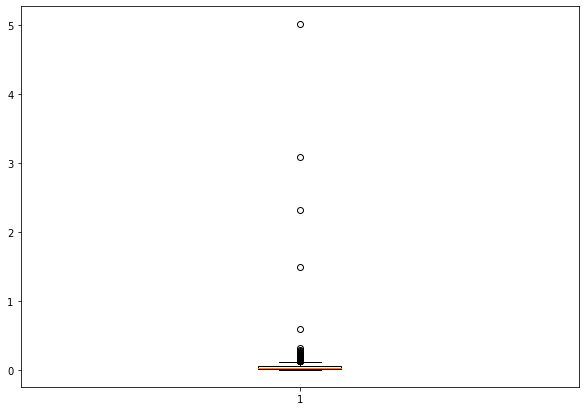

Max Distance for Madagascar is:  5.021566042459334


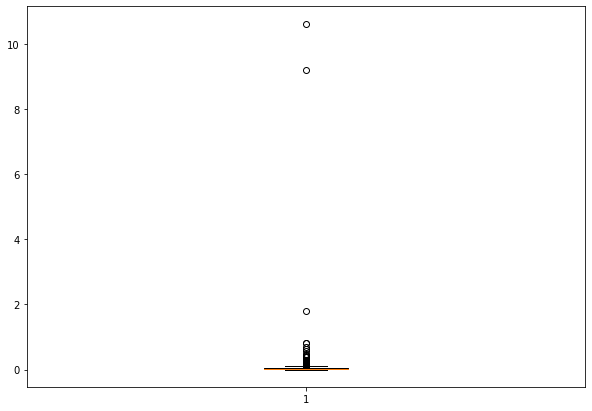

Max Distance for Tanzania is:  10.629913106075673


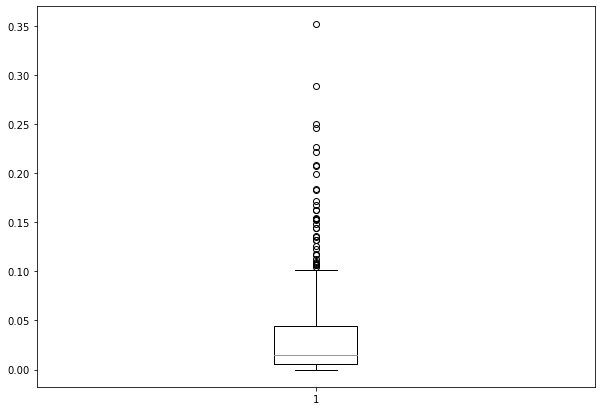

Max Distance for Liberia is:  0.3523686864251703


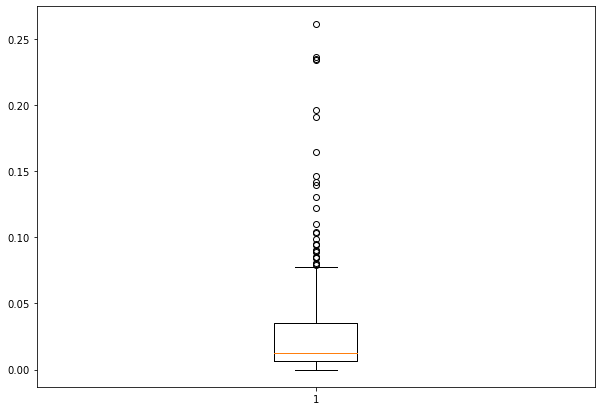

Max Distance for Burundi is:  0.26140154344226885


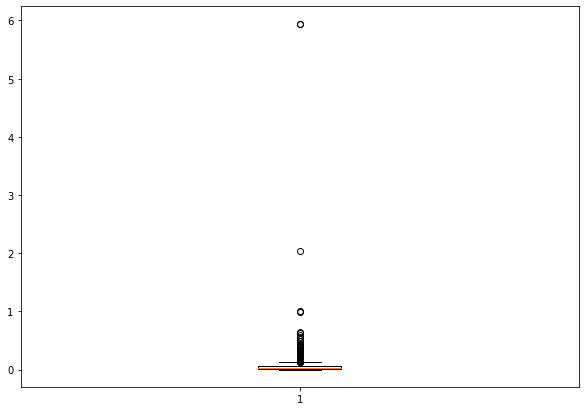

Max Distance for Sudan is:  5.946976869816235


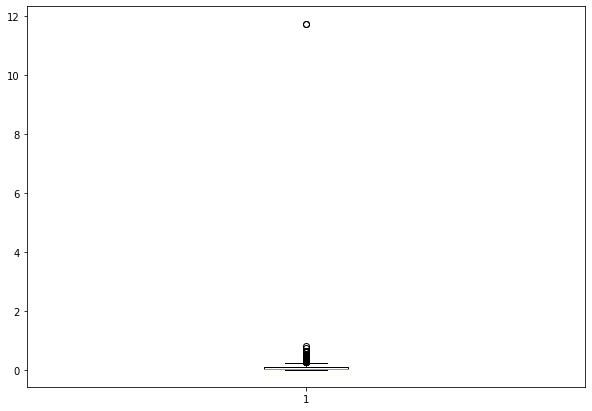

Max Distance for Mauritania is:  11.744475418433975


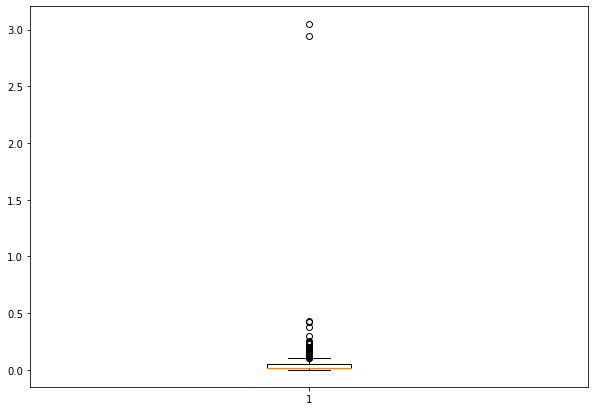

Max Distance for Malawi is:  3.0527394581484777


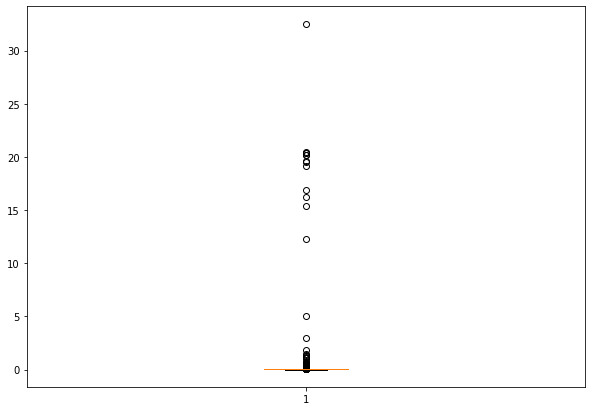

Max Distance for India is:  32.532377546841


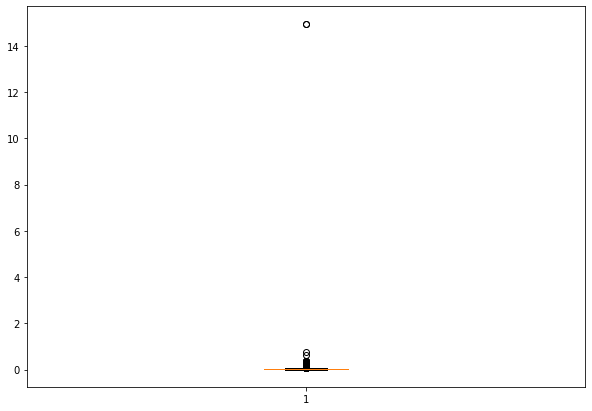

Max Distance for Pakistan is:  14.959364971596544


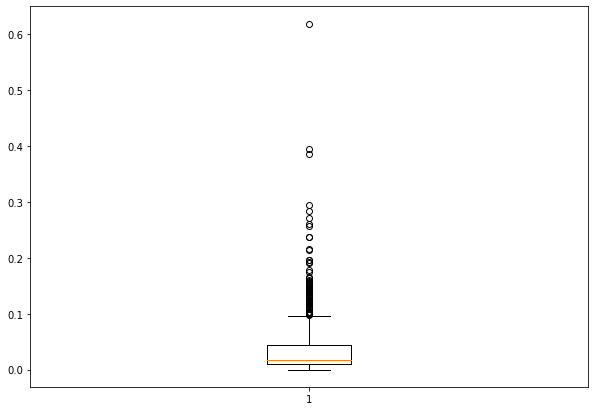

Max Distance for Senegal is:  0.6194490504085062


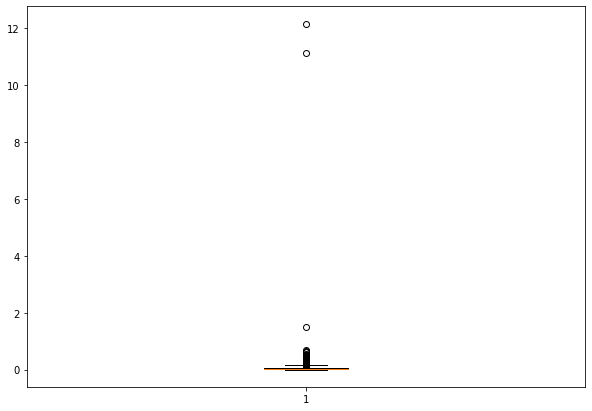

Max Distance for Angola is:  12.166582181842744


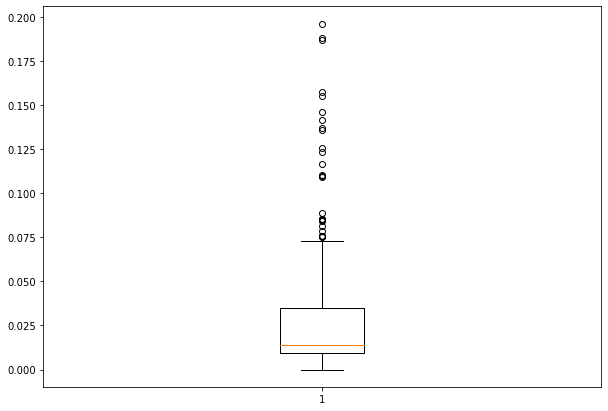

Max Distance for Rwanda is:  0.1964662343406623


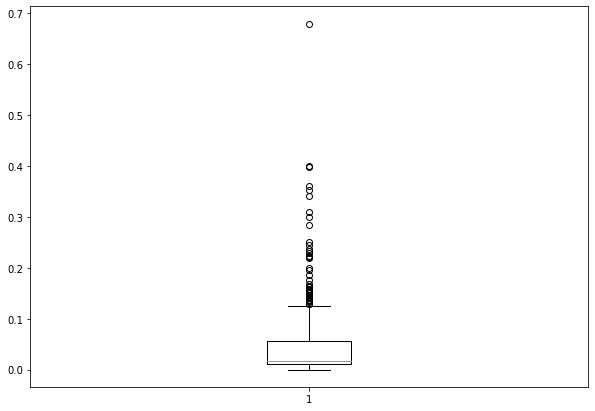

Max Distance for Zimbabwe is:  0.6798834792087545


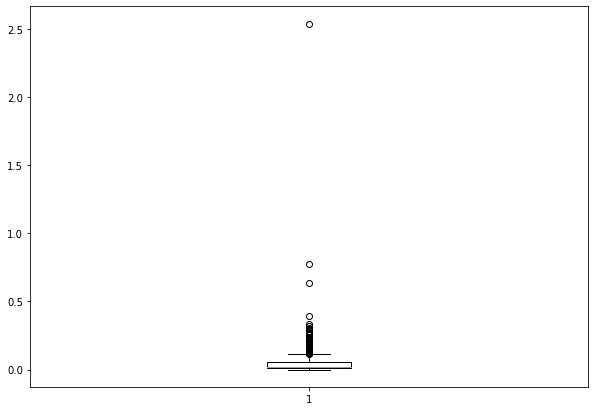

Max Distance for Morocco is:  2.541365003123519


In [16]:
#Calculate Max Distance and Generate Plots for all borders in Parse DB
for countryBorder in data['results']:
    max_distance = maxDistanceCalculator(countryBorder['lat'], countryBorder['lon'])
    print("Max Distance for", countryBorder['countryName'],"is: ", max_distance)

In [17]:
#countries with borders that need to be adjusted: Tanzania, India, Angola, USA (based on Box and Whisker plots)
"""
Max Distance for Angola is:  12.166582181842744
Max Distance for Pakistan is:  14.959364971596544
Max Distance for India is:  32.532377546841
Max Distance for Mauritania is:  11.744475418433975
Max Distance for Tanzania is:  10.629913106075673
Max Distance for Cameroon is:  10.386958898964155
Max Distance for DRC is:  17.027091059716174
Max Distance for United States is:  357.9556018637702
"""

#first find lon/lat of each of the four countries that need to be adjusted
for countryBorder in data['results']:
    name = countryBorder['countryName']
    if (name == 'Tanzania'):
        tanzania_lat = countryBorder['lat']
        tanzania_lon = countryBorder['lon']
        print("Found Tanzania")
    elif (name == 'India'):
        india_lat = countryBorder['lat']
        india_lon = countryBorder['lon']
        print("Found India")
    elif (name == 'Angola'):
        angola_lat = countryBorder['lat']
        angola_lon = countryBorder['lon']
        print("Found Angola")
    elif (name == 'United States'):
        us_lat = countryBorder['lat']
        us_lon = countryBorder['lon']
        print("Found United States")

Found United States
Found Tanzania
Found India
Found Angola


In [18]:
#find the count for how many times distance exceeds 10
def tenDistanceCounter(lat_list, lon_list):
    """
    Counts how many times distance between two consecutive points exceeds 10.
    
    Parameters
    ----------
    lat_list : (list) latitudes for each coordinate
    lon_list : (list) longitudes for each coordinate

    Returns
    -------
    (int)
        > 10 count.
    """
    ten_count = 0
    for coord_key in range(len(lat_list)):
        if (coord_key == (len(lat_list)-1)):
            start_point = [lat_list[coord_key], lon_list[coord_key]]
            end_point = [lat_list[0], lon_list[0]]
            distance = distanceCalculator(start_point, end_point)
            if distance >= 10:
                ten_count+=1
        else:
            start_point = [lat_list[coord_key], lon_list[coord_key]]
            end_point = [lat_list[coord_key+1], lon_list[coord_key+1]]
            distance = distanceCalculator(start_point, end_point)
            if distance >= 10:
                ten_count+=1
    return ten_count

In [19]:
#Example Implementation
print("Ten Count for US: ", tenDistanceCounter(us_lat, us_lon))
print("Ten Count for Tanzania: ", tenDistanceCounter(tanzania_lat, tanzania_lon))
print("Ten Count for India: ", tenDistanceCounter(india_lat, india_lon))
print("Ten Count for Angola: ", tenDistanceCounter(angola_lat, angola_lon))

Ten Count for US:  83
Ten Count for Tanzania:  1
Ten Count for India:  13
Ten Count for Angola:  2


In [20]:
#find coordinate (break point) where distance between two consecutive points > 10
def multipleBorders(lat_list, lon_list):
    """
    Finds coordinate where distance between coordinate and previous coordinate exceeds 10.
    
    Parameters
    ----------
    lat_list : (list) latitudes for each coordinate
    lon_list : (list) longitudes for each coordinate

    Returns
    -------
    None.
    """
    foundSecond = False
    for coord_key in range(len(lat_list)):
        if (coord_key == (len(lat_list)-1)):
            start_point = [lat_list[coord_key], lon_list[coord_key]]
            end_point = [lat_list[0], lon_list[0]]
            distance = distanceCalculator(start_point, end_point)
            if ((distance >= 10) and (not foundSecond)):
                foundSecond = True
                print("Coordinate: ", lat_list[0], lon_list[0])
        else:
            start_point = [lat_list[coord_key], lon_list[coord_key]]
            end_point = [lat_list[coord_key+1], lon_list[coord_key+1]]
            distance = distanceCalculator(start_point, end_point)
            if ((distance >= 10) and (not foundSecond)):
                foundSecond = True
                print("Coordinate: ", lat_list[0], lon_list[0])

In [21]:
#Example Implementation
multipleBorders(tanzania_lat, tanzania_lon)

Coordinate:  -7.993334000000004 39.68249500000002


In [23]:
#Adjusted plotting function (don't connect points with >10 distance between) (visualization tool)
def plotting_noncontiguous(lat, lon):
    """
    Plots borders, without connecting points with >10 distance between consecutive coordinates.
    
    Parameters
    ----------
    lat : (list) latitudes for each coordinate
    lon : (list) longitudes for each coordinate

    Returns
    -------
    None.
    """
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    for point in range(len(lat)):
        if point == len(lat)-1:
            distance = distanceCalculator([lat[point], lon[point]], [lat[0], lon[0]])
            if (distance > 10):
                print("Found distance greater than 10 near end, don't plot")
            else:
                plt.plot([lon[point], lon[0]], [lat[point], lat[0]],
                     color='gray', linestyle='--',
                     transform=ccrs.PlateCarree(),)
        else:
            distance = distanceCalculator([lat[point], lon[point]], [lat[point+1], lon[point+1]])
            if (distance > 10):
                print("Found distance greater than 10 somewhere, don't plot")
            else:
                plt.plot([lon[point], lon[point+1]], [lat[point], lat[point+1]],
                     color='gray', linestyle='--',
                     transform=ccrs.PlateCarree(),)
    plt.show()

Initial Map (Tanzania): 


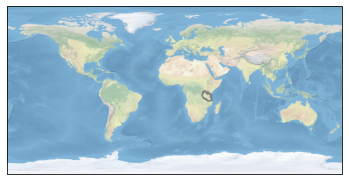

Noncontiguous factored in plotting (Tanzania):
Found distance greater than 10 near end, don't plot


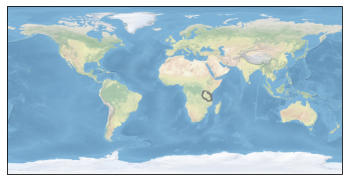

Initial Map (United States): 


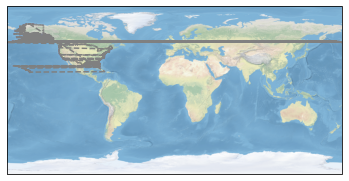

Noncontiguous factored in plotting (United States):
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't

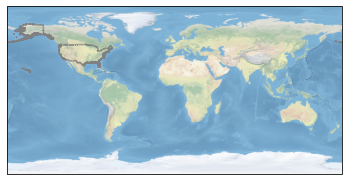

Initial Map (India): 


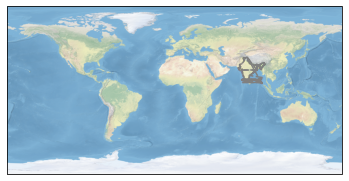

Noncontiguous factored in plotting (India):
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 near end, don't plot


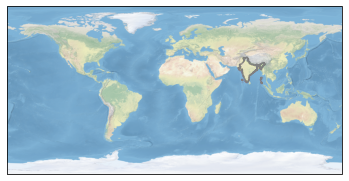

Initial Map (Angola): 


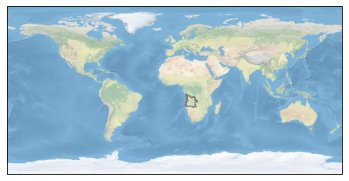

Noncontiguous factored in plotting (Angola):
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 near end, don't plot


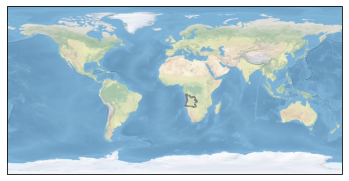

In [24]:
#Example Implementation

print("Initial Map (Tanzania): ")
plottingCountryBorder(tanzania_lat, tanzania_lon)
print("Noncontiguous factored in plotting (Tanzania):")
plotting_noncontiguous(tanzania_lat, tanzania_lon)

print("Initial Map (United States): ")
plottingCountryBorder(us_lat, us_lon)
print("Noncontiguous factored in plotting (United States):")
plotting_noncontiguous(us_lat, us_lon)

print("Initial Map (India): ")
plottingCountryBorder(india_lat, india_lon)
print("Noncontiguous factored in plotting (India):")
plotting_noncontiguous(india_lat, india_lon)

print("Initial Map (Angola): ")
plottingCountryBorder(angola_lat, angola_lon)
print("Noncontiguous factored in plotting (Angola):")
plotting_noncontiguous(angola_lat, angola_lon)

In [28]:
#noncontiguous longitudes and latitudes list generator
def noncontiguous_coords(lat,lon,point_threshold=500):
    """
    Generates longitudes and latitudes with noncontiguous borders factored in.
    
    Parameters
    ----------
    lat : (list) latitudes for each coordinate
    lon : (list) longitudes for each coordinate
    point_threshold : (int) threshold for minimum number of coordinates in each contiguous land mass to keep

    Returns
    -------
    (list)
        [final_latitudes, final_longitudes, end] where:
        final_latitudes : (list) list of lists - each element is a list of latitudes for contiguous land
        final_longitudes : (list) list of lists - each element is a list of longitudes for contiguous land
        end : (bool) True/False based on if first and last coordinate can be connected
    """
    returned_latitudes = []
    returned_longitudes = []
    for point in range(len(lat)):
        end = True
        if point == len(lat)-1:
            distance = distanceCalculator([lat[point], lon[point]], [lat[0], lon[0]])
            if (distance > 10):
                print("Found distance greater than 10 near end, don't plot")
                end = False
        else:
            distance = distanceCalculator([lat[point], lon[point]], [lat[point+1], lon[point+1]])
            if (distance > 10):
                print("Found distance greater than 10 somewhere, don't plot")
                if (len(returned_latitudes) == 0):
                    print("Length of list currently 0")
                    returned_latitudes.append([lat[point]])
                    returned_longitudes.append([lon[point]])
                else:
                    returned_latitudes.append([lat[point]])
                    returned_longitudes.append([lon[point]])
            else:
                if (len(returned_latitudes) == 0):
                    returned_latitudes.append([lat[point]])
                    returned_longitudes.append([lon[point]])
                else:
                    returned_latitudes[len(returned_latitudes)-1].append(lat[point])
                    returned_longitudes[len(returned_longitudes)-1].append(lon[point])
                    
    #only keep land masses/"islands" that have more than point_threshold points defining its borders
    final_latitudes = []
    final_longitudes = []
    for island_key in range(len(returned_latitudes)):
        if (len(returned_latitudes[island_key]) > point_threshold):
            print("Found a sufficiently large 'island'")
            final_latitudes.append(returned_latitudes[island_key])
            final_longitudes.append(returned_longitudes[island_key])
        else:
            print("'Island' too small")
    return (final_latitudes, final_longitudes, end)

In [30]:
#Non-contiguous Implementation for Angola, Tanzania, India, United States

coordinates_noncontiguous = noncontiguous_coords(angola_lat, angola_lon)
angola_lat_noncontiguous = coordinates_noncontiguous[0]
angola_lon_noncontiguous = coordinates_noncontiguous[1]
angola_end = coordinates_noncontiguous[2]
print("Angola:")
print("Number of Contiguous Land Masses (Angola):", len(angola_lat_noncontiguous))
print("Angola End: ", angola_end, "\n")

coordinates_noncontiguous = noncontiguous_coords(us_lat, us_lon,1000)
us_lat_noncontiguous = coordinates_noncontiguous[0]
us_lon_noncontiguous = coordinates_noncontiguous[1]
us_end = coordinates_noncontiguous[2]
print("United States:")
print("Number of Contiguous Land Masses (United States):", len(us_lat_noncontiguous))
print("United States End: ", us_end, "\n")

coordinates_noncontiguous = noncontiguous_coords(india_lat, india_lon)
india_lat_noncontiguous = coordinates_noncontiguous[0]
india_lon_noncontiguous = coordinates_noncontiguous[1]
india_end = coordinates_noncontiguous[2]
print("India:")
print("Number of Contiguous Land Masses (India):", len(india_lat_noncontiguous))
print("India End: ",india_end, "\n")

coordinates_noncontiguous = noncontiguous_coords(tanzania_lat, tanzania_lon)
tanzania_lat_noncontiguous = coordinates_noncontiguous[0]
tanzania_lon_noncontiguous = coordinates_noncontiguous[1]
tanzania_end = coordinates_noncontiguous[2]
print("Tanzania:")
print("Number of Contiguous Land Masses (Tanzania):", len(tanzania_lat_noncontiguous))
print("Tanzania End: ", tanzania_end)

Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 near end, don't plot
'Island' too small
Found a sufficiently large 'island'
Angola:
Number of Contiguous Land Masses (Angola): 1
Angola End:  False 

Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater than 10 somewhere, don't plot
Found distance greater t

In [32]:
#Refactored noncontiguous plotting function (plotting each contiguous land mass) (visualization tool)
def refactored_noncontiguous_plotting(lat_list, lon_list, end):
    """
    Plots each contiguous land mass of a country's borders.
    
    Parameters
    ----------
    lat_list : (list) list of lists - each element is a list of latitudes for contiguous land
    lon_list : (list) list of lists - each element is a list of longitudes for contiguous land
    end : (bool) True/False based on if first and last coordinate can be connected

    Returns
    -------
    None.
    """
    for island in range(len(lat_list)):
        plottingCountryBorder(lat_list[island], lon_list[island], end)

United States: 
Don't connect last two border coordinates (noncontiguous)


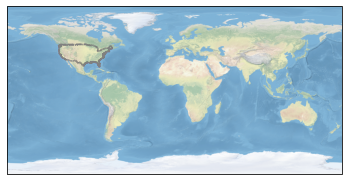

Don't connect last two border coordinates (noncontiguous)


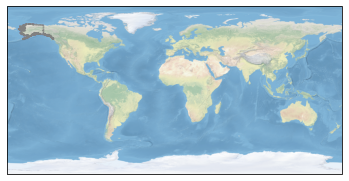



India: 
Don't connect last two border coordinates (noncontiguous)


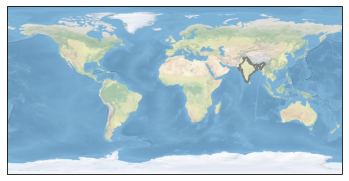



Tanzania: 
Don't connect last two border coordinates (noncontiguous)


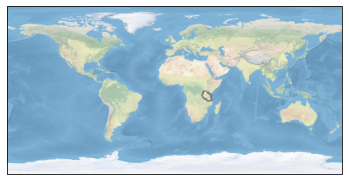



Angola: 
Don't connect last two border coordinates (noncontiguous)


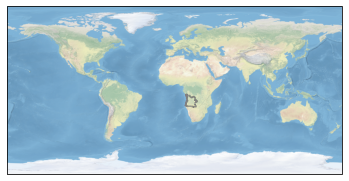

In [33]:
#Implementation of Contiguous Land Mass Plotting

#United States
print("United States: ")
refactored_noncontiguous_plotting(us_lat_noncontiguous, us_lon_noncontiguous, us_end)
print("\n")

#India
print("India: ")
refactored_noncontiguous_plotting(india_lat_noncontiguous, india_lon_noncontiguous, india_end)
print("\n")

#Tanzania
print("Tanzania: ")
refactored_noncontiguous_plotting(tanzania_lat_noncontiguous, tanzania_lon_noncontiguous, tanzania_end)
print("\n")

#Angola
print("Angola: ")
refactored_noncontiguous_plotting(angola_lat_noncontiguous, angola_lon_noncontiguous, angola_end)
print("\n")

In [34]:
#Final Latitude and Longitudes of Borders for non-contiguous country borders

#Tanzania
print("Tanzania Latitudes: ", tanzania_lat_noncontiguous[0])
print("Tanzania Longitudes: ", tanzania_lon_noncontiguous[0], "\n")

#Angola
print("Angola Latitudes: ", angola_lat_noncontiguous[0])
print("Angola Longitudes: ", angola_lon_noncontiguous[0], "\n")

#India
print("India Latitudes: ", india_lat_noncontiguous[0])
print("India Longitudes: ", india_lon_noncontiguous[0], "\n")

#United States
print("United States Land Mass 1 Latitudes: ", us_lat_noncontiguous[0])
print("United States Land Mass 1 Longitudes: ", us_lon_noncontiguous[0])
print("United States Land Mass 2 Latitudes: ", us_lat_noncontiguous[1])
print("United States Land Mass 2 Longitudes: ", us_lon_noncontiguous[1])

Tanzania Latitudes:  [-7.993334000000004, -7.996944999999982, -7.996111999999982, -7.976388999999983, -7.9730559999999855, -7.956112000000019, -7.951945000000023, -7.945833999999934, -7.94389000000001, -7.94389000000001, -7.91333400000002, -7.783610999999951, -7.7333340000000135, -7.7069439999999645, -7.683056000000022, -7.674444999999935, -7.659445000000005, -7.646388999999999, -7.638888999999949, -7.642500999999925, -7.652499999999918, -7.6777779999999325, -7.689166999999998, -7.7369449999999915, -7.763333999999986, -7.875277999999923, -7.879444999999919, -7.907222999999931, -7.911112000000003, -7.919444999999996, -7.974999999999966, -7.989444999999932, -7.993334000000004, -6.210555999999997, -6.213888999999995, -6.213888999999995, -6.201666999999986, -6.198333999999932, -6.193610999999919, -6.186666999999943, -6.153889999999933, -6.143888999999945, -6.13222300000001, -6.129444999999976, -6.130278999999973, -6.132777999999973, -6.136944999999969, -6.141666999999984, -6.18472299999996